In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision.datasets
import torchvision.transforms as T

In [2]:
import time

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
augmentation = T.Compose([
    T.ToTensor(),
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

In [38]:
mnist_train = torchvision.datasets.MNIST(".", train=True, download=True, transform=T.ToTensor())
mnist_train_aug = torchvision.datasets.MNIST(".", train=True, download=True, transform=lambda i: augmentation(i))
mnist_test = torchvision.datasets.MNIST(".", train=False, download=True, transform=T.ToTensor())

In [22]:
batch_size = 128
train_cutoff = int(len(mnist_train) * 0.9)
train_data = D.DataLoader(D.Subset(mnist_train, range(train_cutoff)), batch_size=batch_size, num_workers=4)
train_data_aug = D.DataLoader(D.Subset(mnist_train_aug, range(train_cutoff)), batch_size=batch_size, num_workers=12)
val_data = D.DataLoader(D.Subset(mnist_train, range(train_cutoff, len(mnist_train))), batch_size=batch_size, num_workers=4)
test_data = D.DataLoader(mnist_test, batch_size=batch_size, num_workers=4)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/zeux/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
class Digits(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        self.loss = nn.CrossEntropyLoss()
        
    # image => logit
    def forward(self, x):
        y = self.layers(x)
        return y
    
    # image => prediction, probability
    @torch.no_grad()
    def predict(self, x):
        y = self.forward(x)
        p = F.softmax(y, dim=-1)
        pv, pi = torch.max(p, dim=-1)
        return pi, pv

In [9]:
def train(dataloader, model, optimizer):
    losses = []
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        pred = model.forward(x)
        loss = model.loss(pred, y)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return torch.tensor(losses).mean().item()

In [10]:
@torch.no_grad()
def validate(dataloader, model):
    model.eval()
    loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss += model.loss(pred, y).item()
    return loss / len(dataloader)

In [11]:
@torch.no_grad()
def test(dataloader, model):
    model.eval()
    correct = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= len(dataloader) * batch_size
    print(f"Test accuracy: {(100*correct):>0.1f}%")

In [14]:
def trainloop(model, epochs=5, optimizer=torch.optim.AdamW, **optargs):
    optimizer = optimizer(model.parameters(), **optargs)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    start = time.time()
    train_losses, val_losses = [], []
    for e in range(epochs):
        epoch_start = time.time()
        train_loss = train(train_data_aug, model, optimizer)
        val_loss = validate(val_data, model)
        print(f"Epoch {e}: {time.time()-epoch_start:.2f} sec, train loss {train_loss:>8f}, val loss {val_loss:>8f}, lr {optimizer.param_groups[0]['lr']}")
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    print(f"Train: {epochs} epochs took {time.time()-start:.2f} sec, train loss {train_loss:>8f}, val loss {val_loss:>8f}")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()

Epoch 0: 2.30 sec, train loss 0.622853, val loss 0.130795, lr 0.001
Epoch 1: 2.27 sec, train loss 0.255237, val loss 0.084705, lr 0.001
Epoch 2: 2.39 sec, train loss 0.192464, val loss 0.080952, lr 0.001
Epoch 3: 2.29 sec, train loss 0.160940, val loss 0.064084, lr 0.001
Epoch 4: 2.38 sec, train loss 0.146043, val loss 0.069148, lr 0.001
Epoch 5: 2.39 sec, train loss 0.129860, val loss 0.057909, lr 0.001
Epoch 6: 2.29 sec, train loss 0.118141, val loss 0.053946, lr 0.001
Epoch 7: 2.30 sec, train loss 0.115553, val loss 0.048613, lr 0.001
Epoch 8: 2.26 sec, train loss 0.107827, val loss 0.050407, lr 0.001
Epoch 9: 2.27 sec, train loss 0.104053, val loss 0.047894, lr 0.001
Epoch 10: 2.34 sec, train loss 0.100021, val loss 0.044583, lr 0.001
Epoch 11: 2.29 sec, train loss 0.094087, val loss 0.052284, lr 0.001
Epoch 12: 2.28 sec, train loss 0.089655, val loss 0.041503, lr 0.001
Epoch 13: 2.24 sec, train loss 0.090023, val loss 0.048493, lr 0.001
Epoch 14: 2.31 sec, train loss 0.084670, val

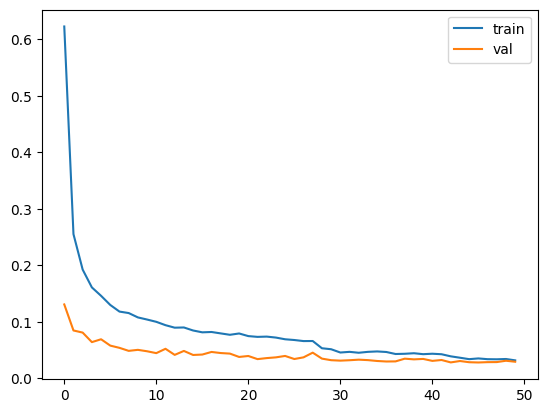

In [39]:
torch.manual_seed(42)
m = Digits().to(device)
trainloop(m, epochs=50, weight_decay=0.01)

<Figure size 640x480 with 0 Axes>

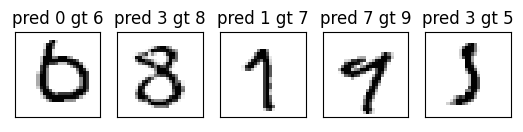

In [42]:
count = 5
plt.figure()
f, axarr = plt.subplots(1, count)
for x, y in mnist_train:
    pi, pv = m.predict(x.to(device))
    if pi.item() != y:
        ax = axarr[count-1]
        ax.set_title(f"pred {pi.item()} gt {y}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(x[0], cmap="binary")
        count -= 1
        if count == 0:
            break

In [41]:
test(test_data, m)

Test accuracy: 98.2%
